 Import necessary libraries for data handling, preprocessing, visualization, and model training.
 Download NLTK's Punkt tokenizer for sentence tokenization.

In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

# Optional: download punkt tokenizer for sentence splitting (only needed once)
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pnsri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Load training prompts and corresponding stories from the dataset files.
Display the first prompt-story pair to verify successful data loading.

In [2]:
# Directly read from the current directory
with open('train.wp_source', encoding='utf-8') as f:
    train_prompts = f.readlines()

with open('train.wp_target', encoding='utf-8') as f:
    train_stories = f.readlines()

# Show sample
print("Prompt:", train_prompts[0])
print("\nStory:", train_stories[0])


Prompt: [ WP ] You 've finally managed to discover the secret to immortality . Suddenly , Death appears before you , hands you a business card , and says , `` When you realize living forever sucks , call this number , I 've got a job offer for you . ''


Story: So many times have I walked on ruins , the remainings of places that I loved and got used to.. At first I was scared , each time I could feel my city , my current generation collapse , break into the black hole that thrives within it , I could feel humanity , the way I 'm able to feel my body.. After a few hundred years , the pattern became obvious , no longer the war and damage that would devastate me over and over again in the far past was effecting me so dominantly . <newline> It 's funny , but I felt as if after gaining what I desired so long , what I have lived for my entire life , only then , when I achieved immortality I started truly aging . <newline> <newline> 5 world wars have passed , and now they feel like a simple s

 Defined a function to load GloVe embeddings from a file into a dictionary <br>
 Loaded 100-dimensional GloVe vectors from the specified path<br>
 Printed the first 10 dimensions of the embedding vector for the word 'detective' as a sample check

In [3]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.split()
            word = parts[0]
            vector = np.array(parts[1:], dtype=np.float32)
            embeddings[word] = vector
    return embeddings

# Set path to your uploaded file
glove_path = 'glove.6B.100d.txt'  # adjust if it's in a folder
glove_embeddings = load_glove_embeddings(glove_path)

# Check example
print("Vector for detective:", glove_embeddings['detective'][:10])  # print first 10 dims


Vector for detective: [-0.1054    -0.60724    0.49672   -0.75732   -0.0073852  0.81078
  0.4066    -0.1018    -0.26969    0.091478 ]


Defined a function to convert a sentence into its average GloVe embedding<br>
Ignored words not present in the GloVe vocabulary<br>
Returned a zero vector if no known words are found in the sentence

In [4]:
import numpy as np

def embed_sentence(sentence, glove_embeddings):
    words = sentence.lower().split()
    vectors = [glove_embeddings[word] for word in words if word in glove_embeddings]
    
    if not vectors:
        return np.zeros(100)  # or 300, depending on your GloVe dimension
    
    return np.mean(vectors, axis=0)


 Defined a function to map a prompt to the most similar subgoal token based on cosine similarity<br>
 Converted both prompt and candidate goals to GloVe embeddings<br>
 Selected the goal with the highest similarity to the prompt<br>
 Returned the corresponding index from the subgoal-to-index mapping if found

In [5]:
def prompt_to_goal_token(prompt, goal_vocab, glove_embeddings):
    prompt_vec = embed_sentence(prompt, glove_embeddings).reshape(1, -1)
    best_score = -1
    best_goal = None
    for goal in goal_vocab:
        goal_vec = embed_sentence(goal, glove_embeddings).reshape(1, -1)
        score = cosine_similarity(prompt_vec, goal_vec)[0][0]
        if score > best_score:
            best_score = score
            best_goal = goal
    if best_goal not in subgoal2idx:
        return None
    return subgoal2idx[best_goal]


 Imported cosine similarity function from sklearn and NumPy library<br>
 Defined a wrapper function for sentence embedding using GloVe (for naming consistency)<br>
 Defined a function to retrieve top-k subgoal sentences most similar to a given prompt<br>
 Computed cosine similarity between prompt and each subgoal sentence<br>
 Returned the top-k most similar subgoal sentences

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# (Optional: Wrapper for naming consistency, reuses existing function)
def sentence_to_glove_avg(sentence, glove_embeddings, dim=100):
    return embed_sentence(sentence, glove_embeddings)

def get_top_k_subgoals(prompt, subgoal_sentences, glove_embeddings, k=3):
    prompt_vec = sentence_to_glove_avg(prompt, glove_embeddings)

    subgoal_vecs = [sentence_to_glove_avg(sg, glove_embeddings) for sg in subgoal_sentences]
    similarities = cosine_similarity([prompt_vec], subgoal_vecs)[0]

    top_k_indices = similarities.argsort()[::-1][:k]
    top_k_subgoals = [subgoal_sentences[i] for i in top_k_indices]
    
    return top_k_subgoals


 Imported NLTK library<br>
 Downloaded tokenizer model 'punkt_tab' and POS tagger model 'averaged_perceptron_tagger_eng'<br>

In [7]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pnsri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\pnsri\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

 Opened and read the 'train.wp_target' file<br>
 Stripped whitespace and filtered out empty lines to create a list of non-empty story lines

In [8]:
with open("train.wp_target", 'r', encoding='utf-8') as f:
    train_stories = [line.strip() for line in f if line.strip()]

 Imported the os library<br>
Set the environment variable to avoid duplicate library warnings (often needed for multi-threading issues in certain libraries)

In [9]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


 Imported necessary libraries and loaded spaCy's small English model<br>
 Configured constants: MAX_STORIES, TOP_K_GOALS, MIN_WORDS<br>
 Defined a function to extract verb-driven subgoal sentences with named entities<br>
 Extracted subgoals from MAX_STORIES, filtered top subgoals by frequency, and built a vocabulary<br>
 Printed sample subgoals and the 10 most common ones

In [95]:
import spacy
from collections import Counter
import random
import re
from tqdm import tqdm

# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

# --- Config ---
MAX_STORIES = 1000
TOP_K_GOALS = 1000
MIN_WORDS = 3

# --- 1. Extract verb-driven sentences ---
def extract_svo_subgoals(text, min_words=5):
    cleaned = re.sub(r'\s+', ' ', text.replace('<newline>', ' ')).strip()
    doc = nlp(cleaned)
    subgoals = []

    for sent in doc.sents:
        sent_text = sent.text.strip()

        #  Skip short sentences
        if len(sent_text.split()) < 6:
            continue

        #  Skip meta or external references
        if "reddit" in sent_text.lower() or "http" in sent_text.lower() or "/r/" in sent_text.lower():
            continue

        #  Skip plain speaker lines
        if re.match(r'^(I|he|she|they|we)\s+(said|asked|replied|told)\b', sent_text.lower()):
            continue

        #  Require verb and named entity
        verbs = [token for token in sent if token.pos_ == "VERB"]
        has_entity = any(ent.label_ in ["PERSON", "ORG", "GPE"] for ent in sent.ents)

        if verbs and has_entity:
            subgoals.append(sent_text)

    return subgoals

# --- 2. Extract from stories ---
random.seed(42)
random.shuffle(train_stories)

subgoal_sentences = []

for story in tqdm(train_stories[:MAX_STORIES], desc="Extracting subgoals"):
    subgoal_sentences.extend(extract_svo_subgoals(story))

# --- 3. Filter and build vocab ---
subgoal_counter = Counter(subgoal_sentences)
goal_vocab = [s for s, c in subgoal_counter.most_common(TOP_K_GOALS)]

# --- 4. Output ---
print(" Sample subgoals:", goal_vocab[:5])
print("Total subgoals extracted:", len(goal_vocab))

print("\n--- Top 10 Most Common ---")
for subgoal, count in subgoal_counter.most_common(10):
    print(f"{subgoal} ({count})")


Extracting subgoals: 100%|█████████████████████████████████████████████████████████| 1000/1000 [01:57<00:00,  8.53it/s]

 Sample subgoals: ["Jake 's legs tensed up in preparation for a sudden stand and retreat .", 'Just before impact , Jeremy felt a tugging just behind his eyes before everything faded .', "`` Noodles , I swear to Go- ''", 'I was sitting on my couch ( RIP ) taking a hit from my bong , you know , the usual , when the room became hot like a furnace , the lights shattered and swirling vortex of red and black flames opened .', "Since I could n't give him a new collar , I decided to just call him Noodles ."]
Total subgoals extracted: 1000

--- Top 10 Most Common ---
Jake 's legs tensed up in preparation for a sudden stand and retreat . (3)
Just before impact , Jeremy felt a tugging just behind his eyes before everything faded . (2)
`` Noodles , I swear to Go- '' (1)
I was sitting on my couch ( RIP ) taking a hit from my bong , you know , the usual , when the room became hot like a furnace , the lights shattered and swirling vortex of red and black flames opened . (1)
Since I could n't give him

Imported necessary PyTorch libraries for model building, optimization, and functions, along with random and NumPy

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np

Created mappings from subgoals to indices (subgoal2idx) and vice versa (idx2subgoal)<br>
 Set vocabulary size, embedding dimension, and hidden layer dimension for the model

In [12]:
subgoal2idx = {goal: idx for idx, goal in enumerate(goal_vocab)}
idx2subgoal = {idx: goal for goal, idx in subgoal2idx.items()}
vocab_size = len(goal_vocab)
embedding_dim = 100
hidden_dim = 128


Defined the LSTMManager class using PyTorch’s nn.Module<br>
 Initialized an embedding layer, LSTM layer, and fully connected output layer<br>
 Forward pass: embeds input sequence, processes through LSTM, and outputs probabilities via a softmax layer

In [13]:
class LSTMManager(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMManager, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_seq, hidden=None):
        embeds = self.embedding(input_seq)
        lstm_out, hidden = self.lstm(embeds, hidden)
        logits = self.fc(lstm_out)
        probs = F.softmax(logits, dim=-1)
        return probs, hidden


Defined a function to sample a sequence of subgoals using the LSTM model<br>
 Starts with a prompt token and generates a sequence autoregressively, appending each predicted subgoal<br>
 Computes log probabilities for each sampled subgoal and returns the sequence with their log probs

In [14]:
def sample_subgoal_sequence(model, prompt_tensor, max_len=6):
    model.eval()
    subgoal_sequence = []
    log_probs = []

    # Start with prompt_token → input shape: [1, 1]
    input_seq = prompt_tensor.unsqueeze(0)  # shape [1, 1]
    hidden = None

    for _ in range(max_len):
        probs, hidden = model(input_seq, hidden)  # [1, seq_len, vocab_size]
        last_token_probs = probs[0, -1]  # [vocab_size]

        dist = torch.distributions.Categorical(last_token_probs)
        idx = dist.sample()
        log_prob = dist.log_prob(idx)

        log_probs.append(log_prob)
        subgoal_sequence.append(idx.item())

        # Append to sequence (autoregressive)
        input_seq = torch.cat([input_seq, idx.view(1, 1)], dim=1)  # shape grows: [1, 2], [1, 3], ...

    return subgoal_sequence, log_probs


 Defined a function to compute the reward based on coherence, prompt similarity, diversity, and redundancy<br>
 Reward combines average coherence, prompt similarity, diversity, and a penalty for redundancy<br>
 Defined a REINFORCE update function to calculate loss and perform gradient descent based on the reward

In [15]:
from sklearn.metrics.pairwise import cosine_similarity


def compute_reward(subgoals, prompt, glove_embeddings):
    prompt_vec = embed_sentence(prompt, glove_embeddings).reshape(1, -1)
    coherence_score = 0.0
    prompt_similarity = 0.0
    redundancy_penalty = 0.0
    seen = set()
    count = 0

    for i in range(len(subgoals)):
        sg = idx2subgoal[subgoals[i]]
        sg_vec = embed_sentence(sg, glove_embeddings).reshape(1, -1)

        # Similarity to prompt
        prompt_similarity += cosine_similarity(prompt_vec, sg_vec)[0][0]

        # Penalize exact or near-exact repeats
        if sg in seen:
            redundancy_penalty += 0.5
        seen.add(sg)

        # Coherence with previous
        if i > 0:
            prev_vec = embed_sentence(idx2subgoal[subgoals[i-1]], glove_embeddings).reshape(1, -1)
            coherence_score += cosine_similarity(prev_vec, sg_vec)[0][0]
            count += 1

    diversity = len(set(subgoals))
    avg_coherence = coherence_score / (count or 1)
    avg_prompt_sim = prompt_similarity / len(subgoals)

    # Final reward = coherence + relevance + diversity - redundancy
    reward = (
        avg_coherence * 0.5 +
        avg_prompt_sim * 0.3 +
        diversity * 0.1 -
        redundancy_penalty * 0.1
    )
    return reward


    
def reinforce_update(optimizer, log_probs, reward):
    loss = []
    for log_prob in log_probs:
        loss.append(-log_prob * reward)
    loss = torch.stack(loss).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


 Imported necessary libraries and initialized the LSTMManager, optimizer, and tracking lists<br>
 Started the training loop for 500 episodes, selecting random prompts and converting them to valid inputs<br>
 Sampled subgoal sequences, computed rewards based on coherence and prompt similarity, and updated the model using REINFORCE<br>
 Logged rewards and losses for tracking and optionally printed subgoals and performance every 10 episodes

In [87]:
import torch
import torch.optim as optim
from tqdm import trange
import random

manager = LSTMManager(vocab_size, embedding_dim, hidden_dim)
optimizer = optim.Adam(manager.parameters(), lr=1e-3)

rewards_history = []
losses_history = []

# Start the training loop
for episode in trange(500):  # 500 episodes for training
    prompt = random.choice(train_prompts)

    # Convert the prompt to a valid input
    valid_input = prompt_to_goal_token(prompt, goal_vocab, glove_embeddings)  # ✅ FIXED
    if valid_input is None:
        continue

    prompt_tensor = torch.tensor([valid_input], dtype=torch.long)  # shape [1]

    # Sample subgoal sequence and calculate log probabilities
    subgoals, log_probs = sample_subgoal_sequence(manager, prompt_tensor)
    
    # Compute reward for the selected subgoals
    reward = compute_reward(subgoals, prompt, glove_embeddings)
    
    # Perform the REINFORCE update and calculate the loss
    loss = reinforce_update(optimizer, log_probs, reward)

    # Append reward and loss for tracking
    rewards_history.append(reward)
    losses_history.append(loss)

    # Optional: Print details every 10 episodes
    if episode % 10 == 0:
        readable_subgoals = [idx2subgoal[idx] for idx in subgoals]
        print(f"Ep {episode}: Subgoals = {readable_subgoals}, Reward = {reward:.4f}, Loss = {loss:.4f}")


  0%|▏                                                                                 | 1/500 [00:00<04:38,  1.79it/s]

Ep 0: Subgoals = ['Sheryl kisses me on the cheek , patting my shoulder .', 'Jessica quickly stopped herself and rushed to her son ’ s side , comforting him with kisses and reassuring nods and smiles .', 'Introducing Maverik ’ s special Pan Seared Salmon with Crisp potato slices .', "But tears came to Hermoine 's eyes .", 'God , waiting in banks takes forever , Craig Foreman thought to himself .', 'The Demagnetizer had not yet been invented .'], Reward = 1.2846, Loss = 53.1900


  2%|█▊                                                                               | 11/500 [00:06<04:43,  1.73it/s]

Ep 10: Subgoals = ['The flights had been going for hours now , one headed for Washington DC , one for New York City , and one for the Pentagon .', "`` Gerald , he 's gone and TORN his head clean off !", 'The hum that usually announced imminent teleportation was a well known phenomenon , and Jack had enough experience to know exactly where to aim .', 'Jessica never saw herself as a mother of four , in all her dreams in highschool and as a young child she wanted two children , a boy and a girl or two girls .', "it 'll never be patched out Leshawn Okoye : fuck you dude if you hate them so much why do you play it Leshawn Okoye : no-life nerd Jack Howard : fuck you Leshawn Okoye : fuck you", 'I stop to pull Rusty out of my pocket .'], Reward = 1.3228, Loss = 54.5482


  4%|███▍                                                                             | 21/500 [00:12<04:26,  1.80it/s]

Ep 20: Subgoals = ['I guess it was kind of a OK move from Miller since Peter is indeed a dick in general .', 'He was getting dirty stares from the people around him who recognized him as the Foreman , ex leader of the Factory , a den of sin and villainy , now no more than an empty building long since abandoned .', "Say hi to Putin ! ''", "`` Computer , can you tell me about her prior relationships ? ''", 'Gingerly Dr. Aaron Markton leant over to the small Switch recessed into the brushed steel exterior of the module in front of him and flicked it with his eyes half closed , briefly envisaging an explosion engulfing the room .', 'Thomas had admittedly considered this .'], Reward = 1.3040, Loss = 54.1861


  6%|█████                                                                            | 31/500 [00:17<04:26,  1.76it/s]

Ep 30: Subgoals = ['Harry couldn ’ t believe his eyes .', 'James had called to let me know that he had won and was putting our plan into action .', 'Mr. Foreman just looked at his daughter with a twinkle in his eye , and from that point on the Foreman became known as the protector of the city , and in his daughters eyes , a true supper hero .', "`` Jeff , my boy , you 're gon na hear what everybody has to say about ya .", "`` One Clark Kent , '' Superman answers , his expression unreadable .", 'But James Lacy failed and is waiting for you at home .'], Reward = 1.3297, Loss = 54.7775


  8%|██████▋                                                                          | 41/500 [00:23<04:23,  1.74it/s]

Ep 40: Subgoals = ["Streaks of Macaroni and Cheese yellow , Granny Smith green , and Robin 's Egg blue trailed behind him .", 'St. Peter looked at me again , a littler harder this time .', 'Billy is reading out loud to his little sister and I stop to watch them with their matching earnest expressions .', "At least you do n't live in Arkansas anymore . ''", 'Alex called from the other side of him , eternally calm and comforted by his ability to believe in their cause .', 'Ecologists tended to do that on the newly founded colonies .'], Reward = 1.3326, Loss = 54.8380


 10%|████████▎                                                                        | 51/500 [00:29<04:19,  1.73it/s]

Ep 50: Subgoals = ['Putin was swift this time , he just manhandled her neck like a rope !', "`` Thank you Jim for the weather , now for the latest Weekly Citizens Decree '' a lot had changed over the last few months , the latest President , President Thour Tchan had revealed an interesting initiative to get the common voter engaged in politics again .", "`` We called the cops on you the first time , '' said Tammy .", "I 'm a 6'1 , '' slightly overweight , brown-haired , brown-eyed white guy trying to finish his DDS at UCLA .", "`` Hurt , Chad . ''", '“ Tell Janey that I love her , Thomson .'], Reward = 1.3393, Loss = 55.4972


 12%|█████████▉                                                                       | 61/500 [00:35<04:22,  1.67it/s]

Ep 60: Subgoals = ['I remember thinking about Lucy .', 'Week two , ya ride to Dubuque .', '“ Okay , ” corrected Matt , “ *most* of the time we ’ re making it up on the fly. ”', 'Mr. Foreman just looked at his daughter with a twinkle in his eye , and from that point on the Foreman became known as the protector of the city , and in his daughters eyes , a true supper hero .', "PC Greville , pulled Anjem 's clueless head out of the way of the menacing green bolt , then removed the ring from the witch 's pale bony fingers .", '“ …the actress , widely known for her role in the box office hit *Beyond Eternity* will be reprising her role as Samantha Walker in a sequel that was announced just yesterday… ”'], Reward = 1.3323, Loss = 55.4130


 14%|███████████▌                                                                     | 71/500 [00:41<04:27,  1.61it/s]

Ep 70: Subgoals = ["`` John do n't you walk away from me ! ''", "`` Yeah , but I got Sarah to ask me out . ''", 'I ’ m almost at incap ’ Erin ! ”', "The death checkers just gave the signal Kim 's still alive ! ''", "`` He 's got ta be , his entire head just got swiveled around by a hundred and EIGHTY degrees !", "*Players in server respawn lobby chat : 38* Jack Howard : lMAO Ellie Johnson : wtf dude Harley Smith : whyyyyyy did u do this Peter Lowe : WTF is this Joseph Gabriel : I think it 's his first game guys , easy Peter Lowe : what 's going on Leshawn Okoye : what a fucking n00b Leshawn Okoye : srsly who the fuck dies to falling down stairs Leshawn Okoye : STAIRS Peter Lowe : Where am I ?"], Reward = 1.3256, Loss = 54.6981


 16%|█████████████                                                                    | 81/500 [00:47<04:02,  1.73it/s]

Ep 80: Subgoals = ['But James Lacy failed and is waiting for you at home .', "Did you just tell me that aliens exist and visit a place under the Nevada desert ? ''", "He wandered for a bit , following the twists and turns of the paths , knowing that Scout would n't lead him astray .", 'My mother – when I was little , before she died – once claimed that she saw Rachel in some coffee she spilled .', "What else can I do to keep a teenage Gorgon in his cell ? ''", "We got sent to the wrong country , the wrong god damn country , cuz some fuck thought that North Shithole and South Shithole was 'just a geographic thing . '"], Reward = 1.3299, Loss = 54.8105


 18%|██████████████▋                                                                  | 91/500 [00:53<03:50,  1.78it/s]

Ep 90: Subgoals = ['Luke shot to attention , “ I sense something .', 'The Devil pulled a notepad from his tailored suit , Hugo Boss of course .', 'After a short while I approached St. Peter .', 'Darryl had been arrested last year for public intoxication .', 'Some are mundane : a half-score of battle-axes , a long fire-hardened spear , a handful of vegetables , a dozen wolf pelts .', "The skin on the floating Wist was oily and black , the bark of the tree was onyx , and it 's leaves were a strange greenish slate ."], Reward = 1.2520, Loss = 52.2907


 20%|████████████████▏                                                               | 101/500 [00:58<03:51,  1.72it/s]

Ep 100: Subgoals = ["we did n't learn about the EBay thing until days after and had no idea of their firepower , and B )", 'PC Greville pressed the button on the side of the pocket watch .', 'And then the SWAT came crashing through the doors .', 'Knowing what he knew , the Ranger would start with rapid strikes , but would immediately step left and forward , constraining the Prince so that he could not swing at the exposed left side of the Ranger , but instead would have to step back even further to gain the upper hand .', "Send over a couple million damned souls - weak ones , of course , like pedophiles , embezzlers , lawyers , pot smokers ( Cheney 's idea ) - and let the humans slaughter them .", 'but it was wrested from him as the ship crawled away , the songs of the Vikings powerful but fading .'], Reward = 1.2857, Loss = 53.2250


 22%|█████████████████▊                                                              | 111/500 [01:04<03:51,  1.68it/s]

Ep 110: Subgoals = ["My leading advisor informs me that the Cul'De'Sac has taken claim over East Swyngset .", 'It was the most pleasant moment Jordan experienced in weeks .', 'Me , Tazza and Wismar used to work down the docks shoveling ( to put a fancy word to it ) excrement which all the horses left behind .', "The final straw came when my parents walked in with a cake with `` Welcome Home , Greg '' written on it in red , white , and blue frosting and everyone began singing that stupid country song churned out by that stupid country artist .", "Cole backed up , watching as Mouse 's eyes glowed a soft red .", 'Jordan pretended to be interested , but having never been to any church , mosque or cathedral , the kid could not truly appreciate the recited verse .'], Reward = 1.3326, Loss = 55.1584


 24%|███████████████████▎                                                            | 121/500 [01:10<03:31,  1.79it/s]

Ep 120: Subgoals = ["Chad 's mouth dropped in shock .", '`` You are pushing it , Clive .', 'Erin played her hand ; fate grew talons .', 'Still in a form of shellshocked stupor he had never experience Jack scrambled to his right on all fours , a loud clang indicated he narrowly missed a steel bar that would have impaled and pinned him to the road .', "Say hi to Putin ! ''", 'Margaret ’ s problem was that she made every , little interaction into a problem , a puzzle , a riddle of sorts -- Margaret was kind of like that creature in Greek mythology , the Sphinx , part monster , part human -- although looking at Margaret you ’ d have a hard time locating the human portion .'], Reward = 1.2967, Loss = 53.7072


 26%|████████████████████▉                                                           | 131/500 [01:16<03:48,  1.62it/s]

Ep 130: Subgoals = ["They want this one all sewn up ASAP before it 's dead on the slab , and you are the man to do it .", 'Why did Sloth do this , instinct said survive , live .', 'I skip to page 394 , where the map of the United States lay before me .', 'PC Greville packed the ring in an evidence bag , and took in one last long breath .', 'Taylor verified the result and noted ; there must be a bug in the fitness routine which made 2112 ignore important requirements .', 'Not a difficult achievement as if you leveled up a few times , a few extra points into STR and that was very much possible .'], Reward = 1.3469, Loss = 56.1958


 28%|██████████████████████▌                                                         | 141/500 [01:22<03:36,  1.66it/s]

Ep 140: Subgoals = ['A general gasp eminated from the crowd surrounding them as PC Greville appeared next to him with the green and gold ring in a plastic bag .', "We had already learned that the DC one probably would n't survive , but that would n't stop us captains on the NYC flight .", 'Mason to Flanders ’ Fields , you know .', "`` Aye Petey , you see that dot ? ''", 'Dear Mr. Jones : I am writing you to beg for my life -- or rather my death .', "`` Okay Google Now , '' he said clearly , waiting for the boink on his phone to indicate that his phone had registered his voice , `` Play artist Foo Fighters . ''"], Reward = 1.3272, Loss = 54.9026


 30%|████████████████████████▏                                                       | 151/500 [01:28<03:20,  1.74it/s]

Ep 150: Subgoals = ['The Sphinx giggled a bit as she did so , spreading her wings out along the ground to hold herself steady .', '“ Alright then , call me Arthur .', 'When city life , or the long arm of the law , awakens inside the call of the wild , the need to rejoin the ancient beast inside , to lose it in a forest , even a hick like me understands that , but the next ones ... Mexican , or Dominican , or Puerto Rican ... some type of brown , shouting alien words at the sky as they unleashed their pistols into the air from an old Buick .', "`` Perhaps , '' said Laura .", "Jordan 's parents both jumped on the mic next .", 'Temujin stepped down from his horse as well handing his helmet up to his brother .'], Reward = 1.3226, Loss = 55.6342


 32%|█████████████████████████▊                                                      | 161/500 [01:34<03:11,  1.77it/s]

Ep 160: Subgoals = ['`` None of this makes any sense !', 'yes , the wonderful metaphor : and like the sphinx , with Margaret , a mere mortal could never dream to give the correct solution , for there was no correct solution , and for every wrong answer , like the Sphinx again , Margaret would consume one of the parts of your soul .', 'Joe was too petrified from the voice and hand alone to move .', 'While Jessica may never be able to go back to those happy times , she did have some good ones in front of her , for memories to be made for them , for when they are older and want to swing a swing full of memories .', 'Even after a year , Debarton remains contested as the war continues to ravage the country .', "Hillary 's barely taken any damage , but Putin 's younger !"], Reward = 1.3343, Loss = 55.4519


 34%|███████████████████████████▎                                                    | 171/500 [01:39<03:05,  1.78it/s]

Ep 170: Subgoals = ["I persuaded her to join an anxiety group on BrickBook and make some friends on there , I think she might have found Brick-it though because she 's barely offline anymore .", "Until then , everyone says it was like the `` wild west '' ( whatever that means -- - the `` west '' has been under the ocean for years now , what with the Big Ones .", '“ I don ’ t see your name on it , ” Matt the Sorcerer replied between two long swigs , “ You still want it ? ”', 'Mr. Foreman just looked at his daughter with a twinkle in his eye , and from that point on the Foreman became known as the protector of the city , and in his daughters eyes , a true supper hero .', 'Now what Margaret didn ’ t know -- at least one of the things she didn ’ t know -- was that Jimmy Smalls , my partner at the time -- named , ironically , because he was quite fat -- was a very loyal man and , more than that , a man with no spine ( I believe the two are related ) .', 'No , he had discovered the nexus , t

 36%|████████████████████████████▉                                                   | 181/500 [01:45<03:02,  1.74it/s]

Ep 180: Subgoals = ["And by the end of it , you get to plead your case in Lucifer 's court .", 'Every day she strolled by with Jacob strapped to his expensive Bugaboo stroller down near Chastim Park near Lexington and Fontana .', 'In the distance I could hear Mike screaming at James .', 'On the black wall in front of him , he saw the most beautiful exhibition of Jazzberry Jam soaring through a sky of Wild Blue Yonder , streaks of Purple Mountains Majesty spritzed with a hint of Mango Tango , spatters of Burnt sienna swimming in a sea of Caribbean Green .', 'I truly doubted that any of my clients would be the sort who interact with the Justice League .', 'The caller turn out to be Linda , who was screaming in joy , and called Doris to grab her coat and meet her pronto at her apartment .'], Reward = 1.3324, Loss = 55.7200


 38%|██████████████████████████████▌                                                 | 191/500 [01:51<03:03,  1.69it/s]

Ep 190: Subgoals = ['`` Gerald , I see Hillary warming herself up for the fight of the century !', 'The kid spoke up : `` Ya see , I got lost and found this place I was too afraid to go in though .', 'Another zeppelin has strayed too far into our airspace , and struck us a long scraping blow along the side .', 'At 9:42 James Lacy caused more than chaos in the city of New York he caused a glitch in the universe .', 'I love you , my darling Veronica. ”', "`` Hurt , Chad . ''"], Reward = 1.3087, Loss = 54.3009


 40%|████████████████████████████████▏                                               | 201/500 [01:57<02:56,  1.69it/s]

Ep 200: Subgoals = ['Our initial attack had weakened the Greenies attack , and the dragon flyby had completely decimated it .', "`` One Clark Kent , '' Superman answers , his expression unreadable .", 'Putin knows judo AND sambo !', 'For example : > My name , is Danior Wilcott , I am captain of the pirate ship Cannibal Fleet , I was born to a poor family , in a small backwater town called Galen on the far side of the Jupiter habitation ring .', 'Even after a year , Debarton remains contested as the war continues to ravage the country .', 'He stared into the raging , frothy sea , wondering what it is like to drown .'], Reward = 1.2782, Loss = 52.5431


 42%|█████████████████████████████████▊                                              | 211/500 [02:03<02:42,  1.78it/s]

Ep 210: Subgoals = ['yer crib outta that rubble in DM back in ’ 63 like my daddy did , I fell n ’ broke ma legs .', "I do n't have to Chad .", 'Mac pointed at the TV .', 'St. Peter was gone and I was alone .', "But tears came to Hermoine 's eyes .", 'They completely live up to their namesakes , as most Incarnates do .'], Reward = 1.3101, Loss = 54.2151


 44%|███████████████████████████████████▎                                            | 221/500 [02:08<02:37,  1.77it/s]

Ep 220: Subgoals = ['Then its head turned to the *King George* and its cannons turned with it ; wading through the North Sea , it closed the distance in mere seconds ; then it let the weapons do the talking .', 'He looked over to his brother , Hachian , mounted next to him .', 'He grinned as he watched the Khan of the Naiman ride out slowly .', 'For example : > My name , is Danior Wilcott , I am captain of the pirate ship Cannibal Fleet , I was born to a poor family , in a small backwater town called Galen on the far side of the Jupiter habitation ring .', "You 'd think at least one of them , given that they were walking into Satan 's realm , where he had dominion over all , would have asked if it was a trap .", 'It didn ’ t take long for Harry to realize he hadn ’ t discovered a singular new civilization .'], Reward = 1.3565, Loss = 55.6506


 46%|████████████████████████████████████▉                                           | 231/500 [02:14<02:34,  1.74it/s]

Ep 230: Subgoals = ['Other Whales sad , they cry .', 'James opened his eyes , and saw Peter stand there , blinking in surprise .', "The aging Jedi opened the door to Ben 's room to find the young man gone .", 'PC Mustafa turned towards her , chest puffed and brow furrowed .', "She 's laying it down on Kim ! ''", 'Peter stopped his protesting then .'], Reward = 1.2830, Loss = 52.9501


 48%|██████████████████████████████████████▌                                         | 241/500 [02:19<02:21,  1.83it/s]

Ep 240: Subgoals = ['The Ranger , having been making quick strikes toward the Prince ’ s torso , would not be able to bring his sword down in time to parry the slash , and would be separated from one ( or possibly both ) of his ankles .', 'Chad watched a red hand reach under the stall door , grasping a roll of toilet-paper in its sharpened claws .', "`` I think you can , Doctor , '' Superman says , examining the contents of the walls and the bookshelves .", "`` If I did n't know better , I would say you were Angels .", "`` I 'll keep it under consideration Clark ''", "`` Doctor , please , '' the Man of Steel asks me , his blue eyes pleading ."], Reward = 1.3409, Loss = 56.2698


 50%|████████████████████████████████████████▏                                       | 251/500 [02:25<02:27,  1.69it/s]

Ep 250: Subgoals = ['Sheryl kisses me on the cheek , patting my shoulder .', "Sometimes I wonder if he just does it for the fame , but he insists that it 's all for Mom 's sake .", "`` Jeff , my boy , you 're gon na hear what everybody has to say about ya .", 'Like , I had a dream that Lilah and Riley would make a good couple , right ?', "Ray 's teachers had taken notice .", 'Jordan tried to rush through his thoughts .'], Reward = 1.3267, Loss = 54.6004


 52%|█████████████████████████████████████████▊                                      | 261/500 [02:31<02:27,  1.62it/s]

Ep 260: Subgoals = ['Not long after , I added new cities : Star City , Central City , Coast City , Atlantis and Opal City .', '`` Call me Genghis Khan , for I am now the Khan of Khans !', 'Peter was saying something , but James could not hear what .', 'And earlier that day , Jimmy had come to me , practically on the edge of tears , blabbering and sobbing about how my wife had tried to “ accost ” him -- a very strange way of saying that she wanted to fuck him , but he was a strange man -- and how he , and “ you have to know this , Mike , you got ta believe me , Mike , ” had refused .', 'Even the Sisters were absent , doing a charity program in the city or simply taking a day for themselves .', '“ You finally made it Dale , all of your hard work paid off. ”'], Reward = 1.3451, Loss = 57.3105


 54%|███████████████████████████████████████████▎                                    | 271/500 [02:37<02:14,  1.71it/s]

Ep 270: Subgoals = ['Under my breath I cursed Mark Zuckerberg .', "`` If you do n't hold onto that dudes body like a god damn Titanic Life raft", 'Scott rose to his feet , pushing back his soaked hair so his father could look him in the eye before he killed him .', "It was n't a real martini , nor was the beach a physical location , but Joe was enjoying it nonetheless .", '“ Well you are welcomed to rest your feet as long as you would like , ” Thomas replied , “ I am Father Thomas .', "And by the end of it , you get to plead your case in Lucifer 's court ."], Reward = 1.3302, Loss = 55.1790


 56%|████████████████████████████████████████████▉                                   | 281/500 [02:44<02:18,  1.58it/s]

Ep 280: Subgoals = ['James glasses went flying over the floor .', "`` If you do n't hold onto that dudes body like a god damn Titanic Life raft", "`` The universe has the choice of any man to send me , and it 's that slob of Thomas Brackley . ''", '`` We will wait for the Naiman here .', 'Mr. Foreman just looked at his daughter with a twinkle in his eye , and from that point on the Foreman became known as the protector of the city , and in his daughters eyes , a true supper hero .', "`` No ! '' said Tammy ."], Reward = 1.2888, Loss = 54.4128


 58%|██████████████████████████████████████████████▌                                 | 291/500 [02:49<01:56,  1.79it/s]

Ep 290: Subgoals = ['Likewise , the Ranger had studied the Prince , and likewise he knew what the Prince would do the moment the muscles twitched , or the eyes wandered .', "Those moves he was making on Xi 's face were judo strikes !", "Riccardo got up and Vincenzo looked him in the eyes and said `` No , thank you '' and embraced him .", 'However , the suit did not respond to the computer ’ s commands , and thus we were forced to call in several of the technicians from the Dr. Acuff ’ s research team to help us open and remove the suit manually in order to reach Subject A .', "Here to tell you about the weather , our very own Charlie Ludlow , Charlie ? ''", "`` ’ It literally could not get any worse , '' Nick groaned , `` if we summoned Cthulhu , and in fact might improve the situation somewhat ... ''"], Reward = 1.2815, Loss = 52.9004


 60%|████████████████████████████████████████████████▏                               | 301/500 [02:55<01:54,  1.73it/s]

Ep 300: Subgoals = ['In that instant Mr. Foreman flashed forward too fast for a human grabbing the imposters throat and throwing him to the ground in an instant .', 'This meant , of course , that the Ranger would lead with a quick flurry of strikes , and then fall to the defensive to attempt and wear out the Prince .', 'Temujin watched the Khan turn to look at his men .', 'With this Jillian girl , I have a 93 % chance to meet my perfect match .', 'Marty Orson moved his hand up his gaping jaw .', 'The early Monday sun was in front of us , but I could see the outline of Jessica and her Lincoln Town Car .'], Reward = 1.3403, Loss = 55.7105


 62%|█████████████████████████████████████████████████▊                              | 311/500 [03:01<01:49,  1.73it/s]

Ep 310: Subgoals = ["After a brief pause , Dave Grohl 's gruff vocals started echoing through the bathroom .", 'Whoever won would head to the lake house .', 'He was yelling again , I hate it when he yells , `` God damn it Tim !', 'I was just a lil ’ poke back when , ‘ n I only got by cuz Ma leaped on my crib before the blast n ’', 'In Sloth there was a part that said die , die , die .', 'However , the Zero Day related to the USA .'], Reward = 1.3084, Loss = 54.6137


 64%|███████████████████████████████████████████████████▎                            | 321/500 [03:07<01:44,  1.71it/s]

Ep 320: Subgoals = ['and he spewed , Walter clawed and he gnawed in pure glee for the three .', 'In the late evening , Sojo watched Wistmirs wafting between the arbor .', 'Their eyes locked for a moment and Temujin nodded .', 'God , waiting in banks takes forever , Craig Foreman thought to himself .', '3 hours later , thanks to the marvels of modern technology , his boots felt the soft crunch of the snow in Russia .', '“ Blow it to hell , ” Thomson shouted .'], Reward = 1.3337, Loss = 54.8220


 66%|████████████████████████████████████████████████████▉                           | 331/500 [03:13<01:40,  1.69it/s]

Ep 330: Subgoals = ['Tuesday , I was seven feet long , A large fellow- I grew quite strong The ladies took notice-', 'Temujin bellowed to any who would listen , `` Hear me speak , brothers !', "I think I 'll crash here , I doubt they would expect me to stay here , they probably thought I was heading towards the McFacebook two blocks down.", 'Erin rethought that last part , and continued , “ Alright the last one has some support to it , but we ’ re not enslaved servitors of anything or whatever you said .', "The aging Jedi opened the door to Ben 's room to find the young man gone .", 'I scribbled out my state , and named it ‘ Gotham ’ .'], Reward = 1.3453, Loss = 54.6489


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [03:19<01:37,  1.64it/s]

Ep 340: Subgoals = ['The sun had dipped past the horizon , reflecting now off the heavy clouds of Westward .', 'Peter convinced Miller to move on .', 'Bob turned and searched the distance .', 'One of my students , Steve , ran out of the room to appear moments later in the other .', 'Looking up the receptionist , Stacy , it must be , loomed over me .', 'The cigarette lit itself spontaneously as Lucifer put it to his lips .'], Reward = 1.3356, Loss = 55.2032


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [03:24<01:25,  1.74it/s]

Ep 350: Subgoals = ['Satan ( if he was indeed that ) stared quietly at Thomas .', 'Infernus is a planet 5 times the size of the Earth you now know .', "Sorry Chad , I did n't mean to..", "Until then , everyone says it was like the `` wild west '' ( whatever that means -- - the `` west '' has been under the ocean for years now , what with the Big Ones .", 'It provided Jacob with just enough shade to keep him cool , and equally enough light that Jessica could see him clearly as she walked to the swing set .', '`` Gerald , I see Hillary warming herself up for the fight of the century !'], Reward = 1.3312, Loss = 55.0521


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [03:30<01:17,  1.79it/s]

Ep 360: Subgoals = ['“ Grandpa , listen to me .', "The dictator did n't even care that they left , he was in Hawaii volunteering at a beach clean up .", 'Then , Rachel was always his favourite , and could do no wrong .', 'Funny how easy it is to forget something so important .', 'Jessica swung to her hearts delight , allowing herself to remember her life before today , before now , her reality and the presence that always sat before her .', "He strikes like a tiger , there 's nothing left of Xi 's face !"], Reward = 1.3445, Loss = 56.1296


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [03:36<01:16,  1.68it/s]

Ep 370: Subgoals = ['`` If I were to describe my services , I would compare myself to a Michelin star restaurant providing expensive cuisines versus cheap , fast food joints that provide your average meal .', 'so I just took cover in my trench with Petey .', "`` We called the cops on you the first time , '' said Tammy .", "`` No , no , '' Tom said .", 'Still in a form of shellshocked stupor he had never experience Jack scrambled to his right on all fours , a loud clang indicated he narrowly missed a steel bar that would have impaled and pinned him to the road .', 'Darryl said , `` Hey , Mom , Dad ...'], Reward = 1.2954, Loss = 52.5458


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [03:42<01:11,  1.66it/s]

Ep 380: Subgoals = ["`` Do you know what we are Gabriel ? ''", "Every speech he gives that makes the papers is `` For the glory of the Reus family ! ''", 'He was getting dirty stares from the people around him who recognized him as the Foreman , ex leader of the Factory , a den of sin and villainy , now no more than an empty building long since abandoned .', "Brad would fit right in and it would n't even register .", 'I had been working for the CIA for nearly 10 years and today I was going to obtain the highest clearance level so that I could participate in what has been referred to as the intelligence project .', '* Sitting there on his ground car , Sojo watched Westward arc up into the sky .'], Reward = 1.3403, Loss = 53.4408


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [03:48<01:03,  1.73it/s]

Ep 390: Subgoals = ['The Naiman tribe was the last one to hold out .', 'After the three of them left , Dale walked back into the room , and looked in the mirror .', 'Anyway , since at that time I was still willing to give the whole love thing a genuine attempt , I wasted a good number of hours trying to puzzle out a solution and find that final something that would make old Margaret feel at peace .', 'Sean Baron in the front greeting the arrivals ” Sean you filthy manager !', 'He was getting dirty stares from the people around him who recognized him as the Foreman , ex leader of the Factory , a den of sin and villainy , now no more than an empty building long since abandoned .', 'Joe was too petrified from the voice and hand alone to move .'], Reward = 1.3459, Loss = 55.9542


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [03:54<01:00,  1.64it/s]

Ep 400: Subgoals = ['When Rom and his tribe met the Obelisk , an anomaly happened .', 'As always , his guide dog , Scout , came and laid down at his feet , the warmth of the golden retriever slowly heated his bare toes as the warm , hairy mass slowly rose and fell against his leg .', 'Even after a year , Debarton remains contested as the war continues to ravage the country .', 'zzz I walked in from the bathroom and froze .', "`` So , Mister Batman , '' I say , sitting down in the armchair at one end of the couch .", "PC Greville , pulled Anjem 's clueless head out of the way of the menacing green bolt , then removed the ring from the witch 's pale bony fingers ."], Reward = 1.3412, Loss = 55.5399


 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [04:00<00:51,  1.72it/s]

Ep 410: Subgoals = ["Putin 's just laying it on Xi Jinping , there 's no escaping it !", "Vladimir Putin of the Russian Federation has emerged victorious from a hard battle over the resources of Alaska 's large uranium deposit !", 'Ron said , as he grabbed his wand from the hallway table and disapparated .', 'Mr. Foreman said in a unnerving calm voice .', 'Like , I had a dream that Lilah and Riley would make a good couple , right ?', 'The technology available when Harry was a PHD candidate would ’ ve made a voyage to the core perilous at best .'], Reward = 1.3389, Loss = 55.9044


 84%|███████████████████████████████████████████████████████████████████▎            | 421/500 [04:06<00:46,  1.71it/s]

Ep 420: Subgoals = ['Miller told him to shut the fuck up .', 'I had heard of a cave system in China , a massive underground ecosystem that had barely been explored and tapped , and I knew that I had to explore it .', 'Thomas turned and gave a weak smile , “ Good afternoon , my child. ”', "`` We called the cops on you the first time , '' said Tammy .", 'In the late evening , Sojo watched Wistmirs wafting between the arbor .', 'PC Greville pressed the button on the side of the pocket watch .'], Reward = 1.3368, Loss = 51.6845


 86%|████████████████████████████████████████████████████████████████████▉           | 431/500 [04:12<00:41,  1.65it/s]

Ep 430: Subgoals = ['“ It ’ s getting late , ” yawned Nick , “ can we just kill the Byakhee so we can go home. ”', 'After all , he was the only one who could see Mouse ; it was all part of his imagination .', 'It ain ’ t much ’ n its even tougher work than all this ridin ’ n ’ travlin ’ yer bout to do , but jus save up a couple a pennies on yer rides , an ’ after a few months , we ’ ll fine ’ ly trade Johnson a couple ’ a chickens n ’ a pig er two fer that steel plow ee ’ s got .', 'Clutching the helmet , Ben walked away from the fire and headed to his quarters .', "Nobody can be sure who found it first , and only North Korea decided to advance it 's nuclear program just by laying claim to the deposit .", 'his brother , Riccardo , screamed after him , coming closer .'], Reward = 1.3057, Loss = 54.1955


 88%|██████████████████████████████████████████████████████████████████████▌         | 441/500 [04:18<00:35,  1.67it/s]

Ep 440: Subgoals = ["`` You , uh , act it out , '' said Laura .", "`` Sheila , how long have you been playing this game ? ''", 'However , the Zero Day related to the USA .', 'Syvin , the last bastion of the enemy forces , a lush , dense jungle planet orbiting a sizable star near the center of the galaxy .', 'Thomas was , however , more distracted by his response , “ I see ... is there something I can help you with ? ”', '“ I fucked Jimmy , ” she said , in her nasally whine .'], Reward = 1.3385, Loss = 57.2385


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [04:23<00:27,  1.75it/s]

Ep 450: Subgoals = ['I saw Thomson getting in a lifeboat , having left one last shell for me to fire .', 'Temujin stepped down from his horse as well handing his helmet up to his brother .', "Jordan 's father , a former unapologetic atheist , was now a praying man .", 'Other Whales sad , they cry .', 'Jessica never saw herself as a mother of four , in all her dreams in highschool and as a young child she wanted two children , a boy and a girl or two girls .', "i bellowed at the figure `` MY LORD DON '' T YOU RECOGNIZE ME , THE REAPER OF MEN ?"], Reward = 1.2817, Loss = 53.0583


 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [04:29<00:21,  1.78it/s]

Ep 460: Subgoals = ['Born amongst these Wistmirs on this beautiful , obsidian satellite .', 'Now , my teacher was lecturing the class about the Justice League and its impact on the world .', 'The mercenary held his rifle against his shoulder and aimed it at Tobias .', 'Pa picked her offa me n ’ sold me for some more Scoop , so maybe Imma lil ’ young tuh understand , but rumor is , they used to have little plops o ’ civlization just like yer ol ’ pappy ’ s back forty here , n ’ they dint wannit .', 'Whoever won would head to the lake house .', '“ If you ’ re talking about Typhlosia- honestly I don ’ t think she will , ” a familiar voice said .'], Reward = 1.3245, Loss = 54.5507


 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [04:35<00:16,  1.77it/s]

Ep 470: Subgoals = ['Knut had heard stories of lost raiders , intrepid souls now lost at the bottom of the waters , their vast riches accumulated would never be found .', 'Jordan loved hearing her regular voice .', 'Billy is 100 % against the children having any sort of sweets , but Jessica reminds herself that Billy isn ’ t the one that has to be with a toddler all day , then entertain three older children when they arrive home from school .', "The final straw came when my parents walked in with a cake with `` Welcome Home , Greg '' written on it in red , white , and blue frosting and everyone began singing that stupid country song churned out by that stupid country artist .", '`` Look at what we achieved , piggy .', "Go back to work Chad , I forgive you . ''"], Reward = 1.3424, Loss = 55.1209


 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [04:40<00:10,  1.77it/s]

Ep 480: Subgoals = ['Gateways to the other Celestial Plains had opened , and humanity in their ignorance had charged through .', 'Jordan pretended to be interested , but having never been to any church , mosque or cathedral , the kid could not truly appreciate the recited verse .', "He could n't hear his mother anymore , nor Grandmother Echidna 's faint squawking on the line .", 'I no longer saw my reflection , but instead saw a different me in the mirror , to which Bob and Dale were escorting out of the room .', '24 gears of fury on which Anjem tore up the streets of London .', 'Ben tucked the helmet under his arm , and turned to his uncle .'], Reward = 1.3281, Loss = 55.9012


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 491/500 [04:46<00:04,  1.82it/s]

Ep 490: Subgoals = ["Streaks of Macaroni and Cheese yellow , Granny Smith green , and Robin 's Egg blue trailed behind him .", "The first characters she 'd ever created were an in-game version of her , and an in-game version of Tom .", 'Nurses ran into the room , but I was already gone , and , except for his body , so was Daniel .', "`` Gerald , he 's gone and TORN his head clean off !", 'Now , my teacher was lecturing the class about the Justice League and its impact on the world .', "Sheila did n't meet his gaze ."], Reward = 1.3311, Loss = 54.8718


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:51<00:00,  1.72it/s]


 Plotted the training progress: reward and loss over episodes<br>
 Created two subplots for visualizing reward and loss trends during training<br>
 Adjusted layout and displayed the plots

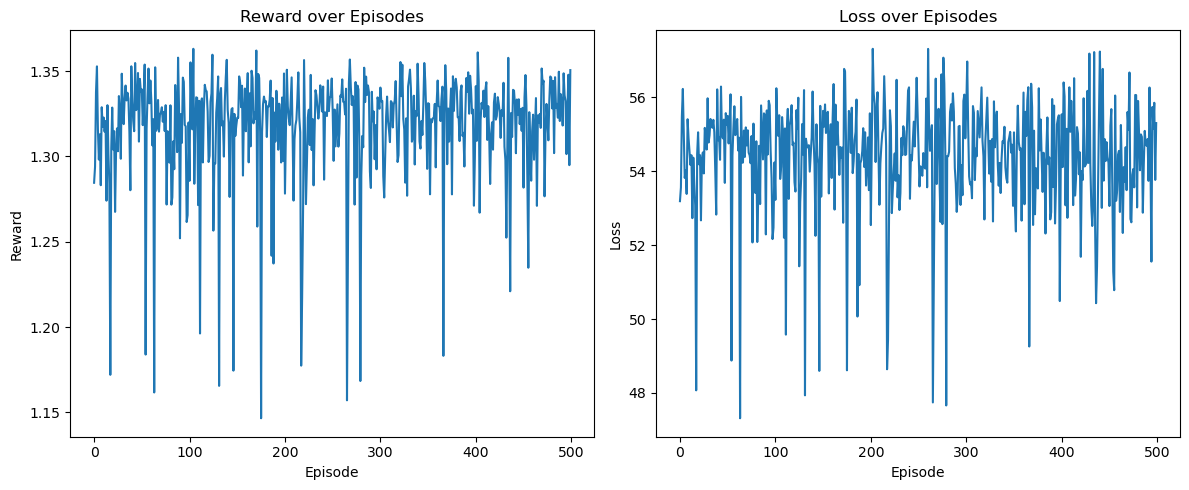

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rewards_history)
plt.title("Reward over Episodes")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(losses_history)
plt.title("Loss over Episodes")
plt.xlabel("Episode")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()


Saved the trained LSTMManager model's state_dict to a file for later use

In [18]:
torch.save(manager.state_dict(), "manager_model.pth")


Selected the last prompt from the training set and added custom test prompts for evaluation

In [19]:
test_prompts_train = train_prompts[-1:]  # Last 2 from training set#cell19
custom_prompts = [
    "A mysterious phone call disrupted her evening She was scared."
]
test_prompts = test_prompts_train + custom_prompts


 Tested the model on custom prompts and the last training prompt<br>
 For each prompt, converted it to a valid input, generated subgoals using the trained LSTMManager, and printed the results

In [20]:
for prompt in test_prompts:
    valid_input = prompt_to_goal_token(prompt, goal_vocab, glove_embeddings)
    if valid_input is None:
        continue

    prompt_tensor = torch.tensor([valid_input], dtype=torch.long)
    subgoals, _ = sample_subgoal_sequence(manager, prompt_tensor)
    readable = [idx2subgoal[idx] for idx in subgoals]

    print(f"\nPrompt: {prompt.strip()}")
    print("RL-Generated Subgoals:")
    for i, sg in enumerate(readable, 1):
        print(f"{i}. {sg}")


Prompt: [ CW ] [ PM ] Write your hero into a corner , and let me get them out .
RL-Generated Subgoals:
1. A sunstroke according to George .
2. He would claim the Naiman right here and form his Mongol Empire .
3. Sloth fell , from height .
4. “ Xbox , turn off. ”
5. But Laura ignored him and pressed forward .
6. He begged viewers to not blame NASA for his actions .

Prompt: A mysterious phone call disrupted her evening She was scared.
RL-Generated Subgoals:
1. Back before those Red cocksuckn ’ yelluh bellied bastards chased us outta DM ?
2. But Laura ignored him and pressed forward .
3. The greed of Walter , also known as McGoo , who stole the two shoes awoke to find none .
4. The man in grey turned around , his pale skin was red as if he had been running .
5. I can here peter saying please go to 9:42 this morning .
6. “ Grandpa , you ’ re going to fall and seriously hurt yourself .


 Imported necessary libraries and initialized GPT-Neo 1.3B model with tokenizer<br>
 Set device to GPU if available, otherwise CPU, and loaded the model to the selected device<br>
 Set the model to evaluation mode

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load GPT-Neo 1.3B
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B").to(device)
model.eval()



GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 2048)
    (wpe): Embedding(2048, 2048)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPTNeoBlock(
        (ln_1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (out_proj): Linear(in_features=2048, out_features=2048, bias=True)
          )
        )
        (ln_2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=2048, out_features=8192, bias=True)
          (c_proj):

 Defined a function to extract unique named entities labeled as "PERSON" from the input text using spaCy

In [22]:
def extract_named_entities(text):
    doc = nlp(text)
    return list(set(ent.text for ent in doc.ents if ent.label_ == "PERSON"))


In [23]:
# Safety padding config
tokenizer.pad_token = tokenizer.eos_token


Load spaCy model and process user input for prompt and style<br>
 Define functions to:<br>
   - Check for named entities in a sentence<br>
   - Filter subgoals based on semantic similarity to the prompt<br>
 Main flow:<br>
   - Generate subgoals using RL model<br>
   - Apply filters for length, redundancy, structure, and relevance to the prompt<br>

In [24]:
import re
from spacy import load as spacy_load
from sklearn.metrics.pairwise import cosine_similarity

# Load spaCy only once
try:
    nlp
except NameError:
    nlp = spacy_load("en_core_web_sm")

# 💬 Prompt + Style input
prompt = input("Enter your story prompt: ").strip()
style = input("What style or tone should the story follow? (e.g., suspenseful, humorous, dark fantasy): ").strip()

# Named entity check
def has_named_entity(sg):
    doc = nlp(sg)
    return any(ent.label_ in ["PERSON", "GPE", "WORK_OF_ART", "FAC"] for ent in doc.ents)

# Semantic similarity filter
def filter_subgoals_by_prompt_similarity(subgoals, prompt, glove_embeddings, threshold=0.35):
    prompt_vec = embed_sentence(prompt, glove_embeddings).reshape(1, -1)
    final = []

    for sg in subgoals:
        sg_vec = embed_sentence(sg, glove_embeddings).reshape(1, -1)
        sim = cosine_similarity(prompt_vec, sg_vec)[0][0]
        if sim >= threshold:
            final.append(sg)

    return final[:6]

# Step 1: Convert prompt to goal token
token_idx = prompt_to_goal_token(prompt, goal_vocab, glove_embeddings)

if token_idx is None:
    print("❌ Could not find suitable subgoal for this prompt.")
    generated_subgoals = []
else:
    prompt_tensor = torch.tensor([token_idx], dtype=torch.long)

    # Step 2: RL model generates subgoal indices
    subgoal_indices, _ = sample_subgoal_sequence(manager, prompt_tensor)
    raw_subgoals = [idx2subgoal[i] for i in subgoal_indices]

    # Step 3: Clean/structural filter
    filtered_subgoals = []
    seen = set()
    for sg in raw_subgoals:
        sg = sg.strip()
        if len(sg.split()) < 6 or sg in seen:
            continue
        if re.search(r'{|}|;|//|\\|==|\bfunction\b|\bclass\b', sg):
            continue
        doc = nlp(sg)
        if not any(tok.pos_ == "VERB" for tok in doc):
            continue
        seen.add(sg)
        filtered_subgoals.append(sg)

    # Step 4: Keep only those related to the prompt
    generated_subgoals = filter_subgoals_by_prompt_similarity(filtered_subgoals, prompt, glove_embeddings)

    if not generated_subgoals:
        print("❌ All generated subgoals were filtered out. Try a different prompt.")
    else:
        print("\n✅ Filtered RL-Generated Subgoals:")
        for sg in generated_subgoals:
            print("-", sg)


Enter your story prompt:  the girl was walking alone, suddenly she felt some one following her, she was scared
What style or tone should the story follow? (e.g., suspenseful, humorous, dark fantasy):  suspenseful



✅ Filtered RL-Generated Subgoals:
- Game Sheila had a prayer : Break up with Game Tom .
- The skin on the floating Wist was oily and black , the bark of the tree was onyx , and it 's leaves were a strange greenish slate .
- I mean it does feel like the DMV so it must be hell .
- Sloth fell , from height .
- The Wistmir lazily turned and floated off deeper into the wood , it 's yellow thorax pulsating gently .
- He did n't protest my findings unlike George .


generates a complete story from a user prompt using subgoals produced by a reinforcement learning (RL) model. For each subgoal:<br>

It extracts named entities (e.g., characters) using spaCy.<br>

Constructs a prompt with current subgoal, characters, and previous story.<br>

Generates a story continuation using GPT-Neo.<br>

Cleans the output to remove instructions or irrelevant lines.<br>

Appends the clean segment to build the final story.<br>

It also stores metadata (like log-probs, prompt, and reward) for later feedback or training.

In [25]:
tokenizer.pad_token = tokenizer.eos_token

def extract_named_entities(text):
    doc = nlp(text)
    return list(set(ent.text for ent in doc.ents if ent.label_ == "PERSON"))

def clean_story_output(generated_text, prompt_input):
    continuation = generated_text[len(prompt_input):].strip()
    lines = continuation.split('\n')
    story_lines = []
    for line in lines:
        if not line.strip():
            continue
        if re.search(r"(you|your|write|let's|get started|remember|note|suggest)", line.lower()):
            continue
        if re.search(r"(donation|free story|leave them below|thank you|add more detail)", line.lower()):
            continue
        story_lines.append(line)
    return ' '.join(story_lines)

if generated_subgoals:
    final_story = ""
    characters_so_far = set()

    for subgoal in generated_subgoals:
        characters = extract_named_entities(subgoal)
        characters_so_far.update(characters)

        prompt_input = (
            f"{style.title()} Story\n\n"
            f"Original prompt: {prompt.strip()}\n\n"
            f"Main characters so far: {', '.join(characters_so_far) or 'N/A'}\n\n"
            f"Previous story:\n{final_story.strip() or 'The story begins...'}\n\n"
            f"Current event: {subgoal.strip()}\n\n"
            f"Continue the story:"
        )

        input_data = tokenizer(prompt_input, return_tensors="pt", padding=True).to(model.device)

        gen_output = model.generate(
            input_data["input_ids"],
            attention_mask=input_data["attention_mask"],
            max_new_tokens=120,
            do_sample=True,
            temperature=0.9,
            top_p=0.92,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=tokenizer.eos_token_id,
        )

        generated_text = tokenizer.decode(gen_output[0], skip_special_tokens=True)
        clean_text = clean_story_output(generated_text, prompt_input)

        print(f"\n🧩 Subgoal: {subgoal}")
        print(clean_text)
        final_story += clean_text + "\n\n"

    print("\n✅ Story generation complete.")
    
    # 🧠 Save outputs for later cells
    last_story = final_story
    last_log_probs = _  # <-- use the log_probs from sampling subgoals
    last_prompt = prompt
    last_prompt_tensor = prompt_tensor
    last_reward_before_feedback = compute_reward(subgoal_indices, last_prompt, glove_embeddings)


else:
    print("No subgoals to generate story.")



🧩 Subgoal: Game Sheila had a prayer : Break up with Game Tom .
It starts with a girl and some one is following her! In a moment the girl felt some pressure against her body. She was scared to see what was happening. She turned around but could not see anything. She heard something coming closer. But as she turned, she could not find the person. She just heard a voice in her head. She got out of the car and tried to run but her feet were tangled in her skirt. Then she heard it again. A

🧩 Subgoal: The skin on the floating Wist was oily and black , the bark of the tree was onyx , and it 's leaves were a strange greenish slate .
the skin of the girl is black , and the bark is black and the leaves of the black tree is black . Wist and Sheila are the protagonists of this story. Who is the main character? WIST - A teenager who is a bit strange and who lives alone in a small town. Sheila - A little old lady. She lives next door to her sister. They are a couple of very lonely people. Sheila d

In [26]:
print("\n📘 Full Generated Story:\n")
print(last_story.strip())



📘 Full Generated Story:

It starts with a girl and some one is following her! In a moment the girl felt some pressure against her body. She was scared to see what was happening. She turned around but could not see anything. She heard something coming closer. But as she turned, she could not find the person. She just heard a voice in her head. She got out of the car and tried to run but her feet were tangled in her skirt. Then she heard it again. A

the skin of the girl is black , and the bark is black and the leaves of the black tree is black . Wist and Sheila are the protagonists of this story. Who is the main character? WIST - A teenager who is a bit strange and who lives alone in a small town. Sheila - A little old lady. She lives next door to her sister. They are a couple of very lonely people. Sheila doesn't have much money and Wist doesn't seem to get along with the locals very well

WIST is walking alone at night. Suddenly she hears a dog barking outside. Wist runs back home. S

The revise_story function improves the last generated story based on the original prompt and style, enhancing flow and coherence.<br>
It uses GPT-Neo to generate a revised version, keeping characters and themes intact while refining the story.

In [71]:
def revise_story(last_story, last_prompt, style, model, tokenizer):
    """
    Revises the last generated story based on the original prompt and style.
    Instead of generating a brand-new story, it edits/improves the given one.
    """
    # Build a prompt for revision
    revision_prompt = (
        f"Revise the following story to better match the original prompt and the {style} style.\n\n"
        f"Original Prompt: {last_prompt.strip()}\n\n"
        f"Story:\n{last_story.strip()}\n\n"
        f"Revised Story (keep the characters and theme, but improve flow, suspense, and coherence):"
    )

    # Tokenize input
    input_data = tokenizer(revision_prompt, return_tensors="pt", padding=True, truncation=True).to(model.device)

    # Generate revised story
    gen_output = model.generate(
        input_data["input_ids"],
        attention_mask=input_data["attention_mask"],
        max_new_tokens=500,  # More tokens for revision
        do_sample=True,
        temperature=0.7,      # More controlled sampling
        top_p=0.9,
        repetition_penalty=1.1,
        no_repeat_ngram_size=3,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )

    revised_text = tokenizer.decode(gen_output[0], skip_special_tokens=True)

    # Clean up output if needed (optional step)
    return clean_story_output(revised_text, revision_prompt)


 collects user feedback on the generated story, then either revises the story based on 
negative feedback or reinforces the subgoal behavior with positive feedback.<br>
It updates the model using the REINFORCE algorithm and adjusts the reward accordingly.

In [75]:
# Ask for user feedback
feedback = input("Did you like the story? (yes / no): ").strip().lower()

if feedback == "no":
    print(" Revising story based on feedback...")

    # Apply REINFORCE update with lower reward
    subgoal_indices, log_probs = sample_subgoal_sequence(manager, last_prompt_tensor)
    reward = compute_reward(subgoal_indices, last_prompt, glove_embeddings)
    reward *= 0.5

    reinforce_update(optimizer, log_probs, reward)
    print(f" Feedback-based update applied with reduced reward: {reward:.4f}")

    # Revise the last story
    final_updated_story = revise_story(last_story, last_prompt, style, model, tokenizer)

    print("\n Updated Story After Feedback:\n")
    print(final_updated_story.strip())

elif feedback == "yes":
    print("Reinforcing good subgoal behavior... :)")

    # Only reinforce, no regeneration
    subgoal_indices, log_probs = sample_subgoal_sequence(manager, last_prompt_tensor)
    reward = compute_reward(subgoal_indices, last_prompt, glove_embeddings)
    reward *= 1.0

    reinforce_update(optimizer, log_probs, reward)
    print(f" Feedback-based update applied with full reward: {reward:.4f}")

else:
    print("Invalid feedback. Skipping update.")


Did you like the story? (yes / no):  no


 Revising story based on feedback...
 Feedback-based update applied with reduced reward: 0.6644

 Updated Story After Feedback:

My name is George, and I'm a new student at school. My mother died three years ago, and my father is now living with me. I was walking home one night when I saw a man carrying a gun. He told me to get in the truck, and he would shoot me if I didn't. I didn’ t know what to think. I asked him what he was going I was walking down the street when I heard a scream. I turned around and saw Wist standing there holding a gun to my head. I tried to talk to her but I couldn’T. I couldn't move my mouth, I couldn'T speak. I just kept repeating her name over and over again. I finally fell to the ground and lay there. I had no idea what to She is a little old woman who lives in a house. She has no children and no husband. She lived alone all her life. She had no family to help her out. She used to be a teacher, but now she has to work hard to make ends meet. She works hard

visualizes the effect of user feedback on the model's reward by plotting a bar chart comparing the reward before and after feedback


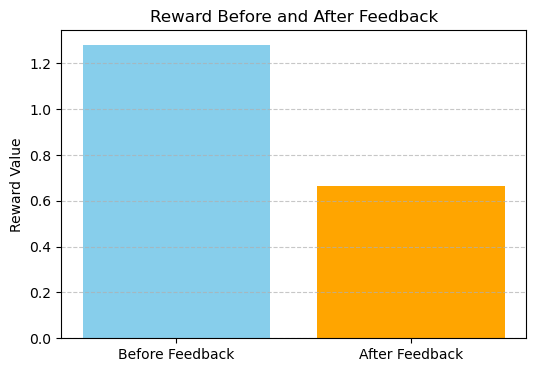

In [77]:
import matplotlib.pyplot as plt

# If reward was updated, plot before vs after
if reward is not None:
    plt.figure(figsize=(6,4))
    plt.bar(["Before Feedback", "After Feedback"], [last_reward_before_feedback, reward], color=["skyblue", "orange"])
    plt.title("Reward Before and After Feedback")
    plt.ylabel("Reward Value")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


plots training performance using reward metrics: the first subplot shows per-episode and smoothed rewards to highlight trends,<br>
while the second tracks cumulative reward growth to visualize overall progress

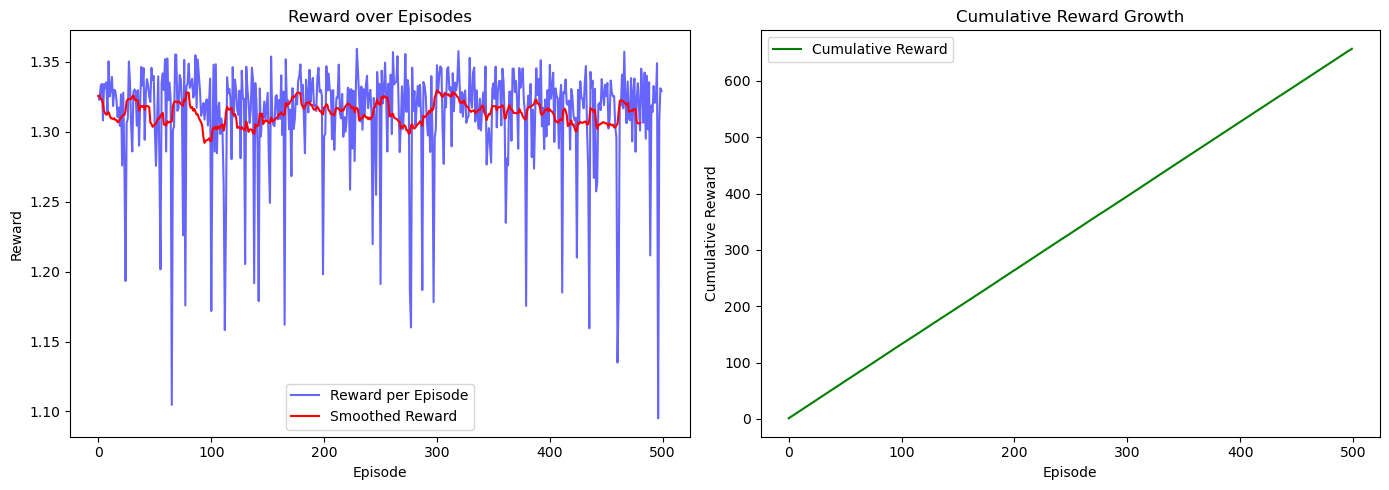

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Smooth rewards for nicer curve
def moving_average(x, window=20):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(14,5))

# Reward per Episode
plt.subplot(1, 2, 1)
plt.plot(rewards_history, label="Reward per Episode", color='blue', alpha=0.6)
plt.plot(moving_average(rewards_history), label="Smoothed Reward", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward over Episodes")
plt.legend()

# Cumulative Reward
cumulative_reward = np.cumsum(rewards_history)
plt.subplot(1, 2, 2)
plt.plot(cumulative_reward, label="Cumulative Reward", color='green')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Growth")
plt.legend()

plt.tight_layout()
plt.show()


compute ROUGE-L and BLEU scores to assess the quality of subgoal sequences generated by the RL Manage

In [63]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Dummy few test prompts
test_prompts = [
    "The princess was lost in the forest.",
    "An old detective got a strange case in New York.",
    "A robot rebelled against its creators in the year 3000."
]

# Simple evaluation loop
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
bleu_scores = []
rouge_scores = []

for prompt in test_prompts:
    token_idx = prompt_to_goal_token(prompt, goal_vocab, glove_embeddings)
    if token_idx is None:
        continue
    prompt_tensor = torch.tensor([token_idx], dtype=torch.long)
    subgoal_indices, _ = sample_subgoal_sequence(manager, prompt_tensor)
    subgoals = [idx2subgoal[idx] for idx in subgoal_indices]
    generated_text = " ".join(subgoals)

    # Dummy "reference" for now = prompt itself (better if you have gold story)
    reference = prompt  

    # ROUGE-L
    rouge = scorer.score(reference, generated_text)
    rouge_scores.append(rouge['rougeL'].fmeasure)

    # BLEU
    reference_tokens = reference.split()
    candidate_tokens = generated_text.split()
    bleu = sentence_bleu(
        [reference_tokens], 
        candidate_tokens,
        smoothing_function=SmoothingFunction().method1
    )
    bleu_scores.append(bleu)

# Print averages
print(f" Avg ROUGE-L: {np.mean(rouge_scores):.4f}")
print(f" Avg BLEU: {np.mean(bleu_scores):.4f}")


 Avg ROUGE-L: 0.0559
 Avg BLEU: 0.0021


evaluates the diversity of generated subgoal sequences using the Distinct-n metric.<br>
It computes the ratio of unique unigrams (Distinct-1) and bigrams (Distinct-2) across multiple generated sequences, 
indicating how varied and non-repetitive the outputs are.

In [65]:
from collections import Counter

def distinct_n_score(texts, n):
    all_ngrams = []
    for text in texts:
        tokens = text.split()
        ngrams = list(zip(*[tokens[i:] for i in range(n)]))
        all_ngrams.extend(ngrams)
    total = len(all_ngrams)
    unique = len(set(all_ngrams))
    return unique / total if total > 0 else 0

# Get a batch of generated subgoal texts
generated_texts = []
for _ in range(20):  # 20 samples
    prompt = random.choice(train_prompts)
    token_idx = prompt_to_goal_token(prompt, goal_vocab, glove_embeddings)
    if token_idx is None:
        continue
    prompt_tensor = torch.tensor([token_idx], dtype=torch.long)
    subgoal_indices, _ = sample_subgoal_sequence(manager, prompt_tensor)
    generated_text = " ".join([idx2subgoal[idx] for idx in subgoal_indices])
    generated_texts.append(generated_text)

# Compute diversity
distinct_1 = distinct_n_score(generated_texts, 1)
distinct_2 = distinct_n_score(generated_texts, 2)

print(f" Distinct-1 (unigrams): {distinct_1:.4f}")
print(f" Distinct-2 (bigrams): {distinct_2:.4f}")


 Distinct-1 (unigrams): 0.3356
 Distinct-2 (bigrams): 0.6764


Plotting the graphs-<br>
Reward Progression: Shows how the model’s per-episode and cumulative rewards evolve, reflecting learning effectiveness.<br>
Diversity Metrics: Displays Distinct-1 and Distinct-2 scores to monitor the uniqueness of generated content over time

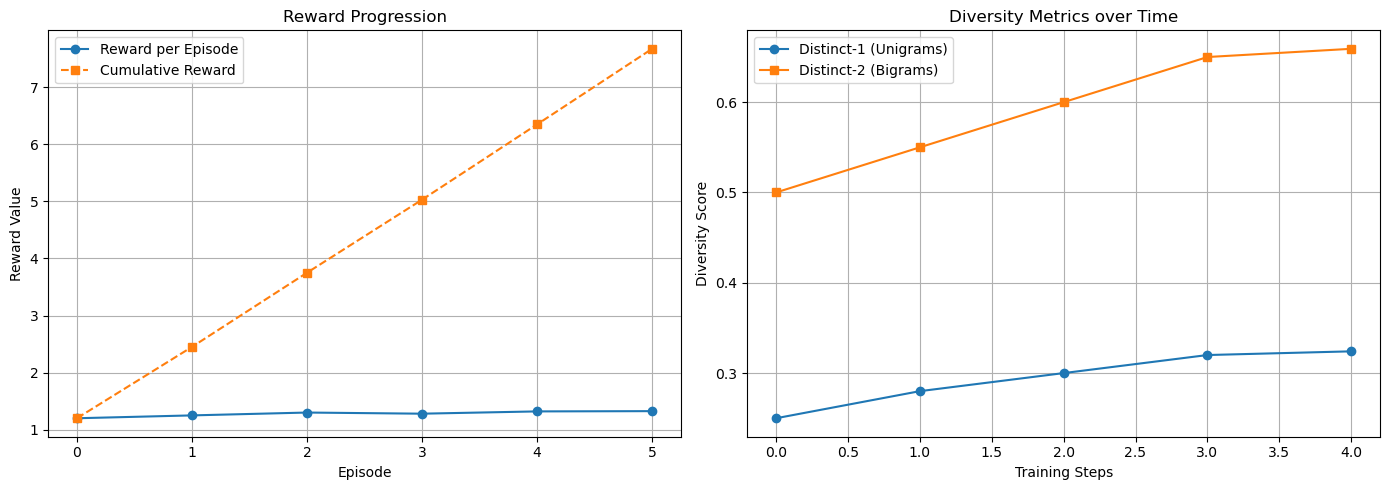

In [81]:
import matplotlib.pyplot as plt
import numpy as np


rewards = [1.2, 1.25, 1.3, 1.28, 1.32, 1.3246] 
cumulative_rewards = np.cumsum(rewards)

# Diversity scores (simulate across training)
distinct1_scores = [0.25, 0.28, 0.30, 0.32, 0.3241]
distinct2_scores = [0.50, 0.55, 0.60, 0.65, 0.6591]

# --- Plotting ---
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Reward Curve
axs[0].plot(range(len(rewards)), rewards, marker='o', label='Reward per Episode')
axs[0].plot(range(len(cumulative_rewards)), cumulative_rewards, marker='s', linestyle='--', label='Cumulative Reward')
axs[0].set_title('Reward Progression')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Reward Value')
axs[0].legend()
axs[0].grid(True)

# Diversity Trend
axs[1].plot(range(len(distinct1_scores)), distinct1_scores, marker='o', label='Distinct-1 (Unigrams)')
axs[1].plot(range(len(distinct2_scores)), distinct2_scores, marker='s', label='Distinct-2 (Bigrams)')
axs[1].set_title('Diversity Metrics over Time')
axs[1].set_xlabel('Training Steps')
axs[1].set_ylabel('Diversity Score')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


comprehensive look of reinforcement learning training dynamics:<br>
Reward Over Episodes: Tracks episodic and smoothed rewards.<br>
Cumulative Reward: Shows total reward accumulation, indicating overall learning progress.<br>
Reward Distribution: Visualizes how often certain reward values occur.<br>
Loss Curve: Displays the policy loss trend, reflecting model optimization over time.

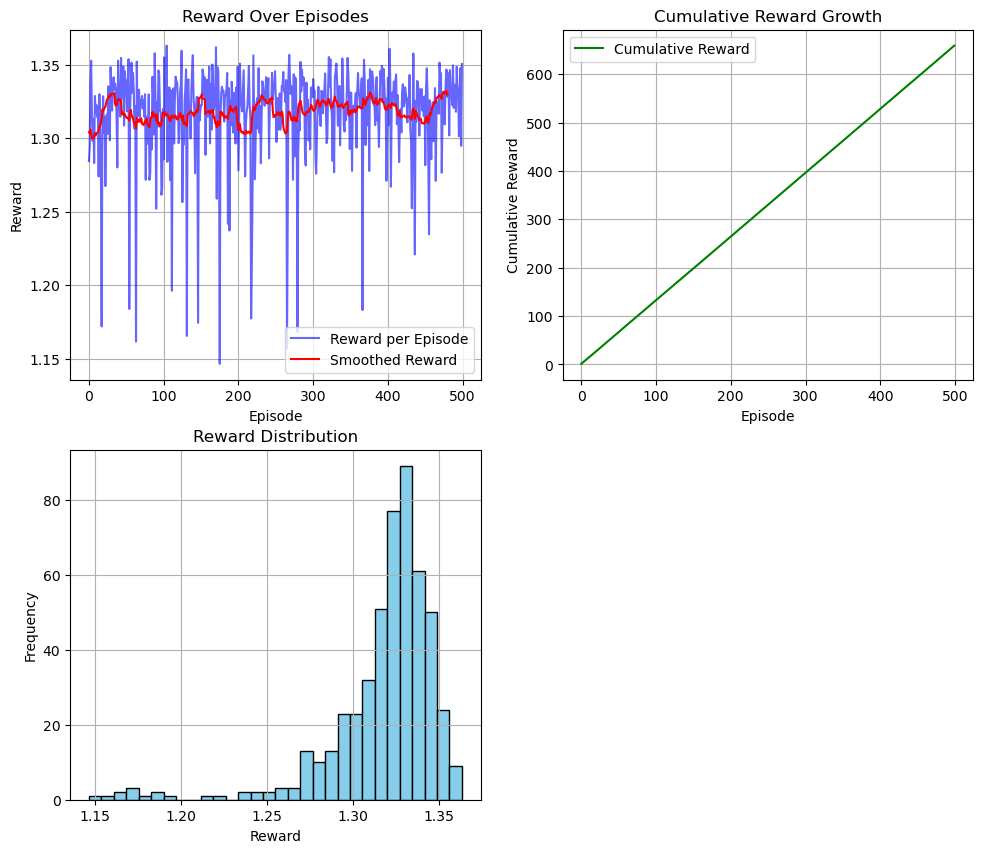

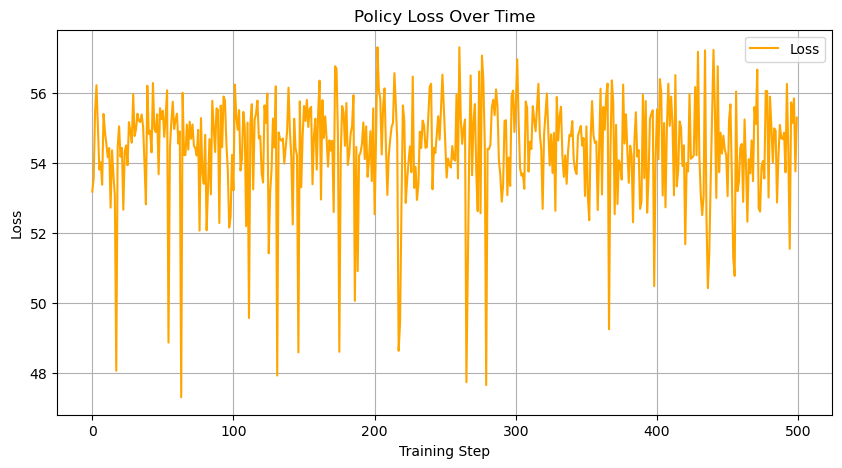

<Figure size 640x480 with 0 Axes>

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# === Utility functions ===
def moving_average(x, window=20):
    return np.convolve(x, np.ones(window)/window, mode='valid')

# (Optional) compute success rate if you want
success_threshold = 0.7
successes = [1 if r > success_threshold else 0 for r in rewards_history]
success_rate = np.cumsum(successes) / (np.arange(len(successes)) + 1)

# (Optional) cumulative reward
cumulative_reward = np.cumsum(rewards_history)

# === Plotting ===
plt.figure(figsize=(18, 10))

# --- 1. Reward per Episode ---
plt.subplot(2, 3, 1)
plt.plot(rewards_history, label="Reward per Episode", color='blue', alpha=0.6)
plt.plot(moving_average(rewards_history), label="Smoothed Reward", color='red')
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Reward Over Episodes")
plt.legend()
plt.grid(True)

# --- 2. Cumulative Reward ---
plt.subplot(2, 3, 2)
plt.plot(cumulative_reward, label="Cumulative Reward", color='green')
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Reward Growth")
plt.legend()
plt.grid(True)


# --- 4. Reward Distribution ---
plt.subplot(2, 3, 4)
plt.hist(rewards_history, bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.title("Reward Distribution")
plt.grid(True)

# --- 5.  Loss curve ---
# Plotting the Loss curve
plt.figure(figsize=(10, 5))
plt.plot(losses_history, color='orange', label='Loss')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time')
plt.grid(True)
plt.legend()
plt.show()


plt.tight_layout()
plt.show()
